# Kuffman data processing
## Xiaonan Wang
## 21May2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


# Read in data and QC

In [2]:
# read in metadata
meta =pd.read_csv('/home/xw251/rds/rds-bg200-hphi-gottgens/users/ycks3/laurenti/analysis_laurenti/serena/qa22_qa81_with_without_PD/toronto_projection_28Apr2020/scRNA_HSC_anno.csv', index_col=0)
print(meta.shape)
display(meta.head(1))

# read in counts
count = pd.read_csv('/home/xw251/rds/rds-bg200-hphi-gottgens/users/ycks3/laurenti/analysis_laurenti/serena/qa22_qa81_with_without_PD/toronto_projection_28Apr2020/scRNA_HSC_rawcounts.csv', index_col=0).T
print(count.shape)

(1369, 20)


Donor  CD45RA  CD34  CD38  \
Cell                                                                            
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...  mPB-4     615  8436    60   

                                                       CD49f      CD90  \
Cell                                                                     
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...  7.800573  6.898715   

                                                    log10_total_counts  \
Cell                                                                     
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...            5.369581   

                                                    log10_total_features_by_counts  \
Cell                                                                                 
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...                        3.236537   

                                                    pct_counts_MT   S.Score  \
Cell                                                                          
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...       4.443714  0.003396   

                                                    G2M.Score  Cycle.Score  \
Cell                                                                         
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...  -0.018723     0.003396   

                                                        Cycling DCA_split  \
Cell                                                                        
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...  not_cycling     train   

                                                     n_counts  size_factors  \
Cell                                                                          
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...  234389.33      1.714126   

                                                    initial_size_unspliced  \
Cell                                                                         
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...                 63318.0   

                                                    initial_size_spliced  \
Cell                                                                       
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...              159796.0   

                                                    initial_size  \
Cell                                                               
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...      223114.0   

                                                                        Tissue  
Cell                                                                            
onefilepercell_BM1_1_AACACGCATCTG_and_others_HM...  Mobilized Peripheral Blood

(1369, 28970)


In [3]:
# Create anndata obj
adata = anndata.AnnData(X=count, obs=meta)
adata

AnnData object with n_obs × n_vars = 1369 × 28970 
    obs: 'Donor', 'CD45RA', 'CD34', 'CD38', 'CD49f', 'CD90', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_MT', 'S.Score', 'G2M.Score', 'Cycle.Score', 'Cycling', 'DCA_split', 'n_counts', 'size_factors', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Tissue'

In [4]:
# define QC thresholds
cutoff = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(10**4.3),
           'fGenes:nTotal': 0,
           'nHCGenes': 0,
           'mito:nGenes': 0.15,
           'nERCC:nMapped': 0.2
          }

mito_genes: ['MT-TA', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-ND6', 'MT-TE', 'MT-TF', 'MT-RNR1', 'MT-RNR2', 'MT-TL1', 'MT-ND1', 'MT-TI', 'MT-TM', 'MT-ND2', 'MT-TW', 'MT-CO1', 'MT-TD', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-TG', 'MT-ND3', 'MT-TR', 'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-CYB']
Number of passed cells: 1282
Number of failed cells: 87


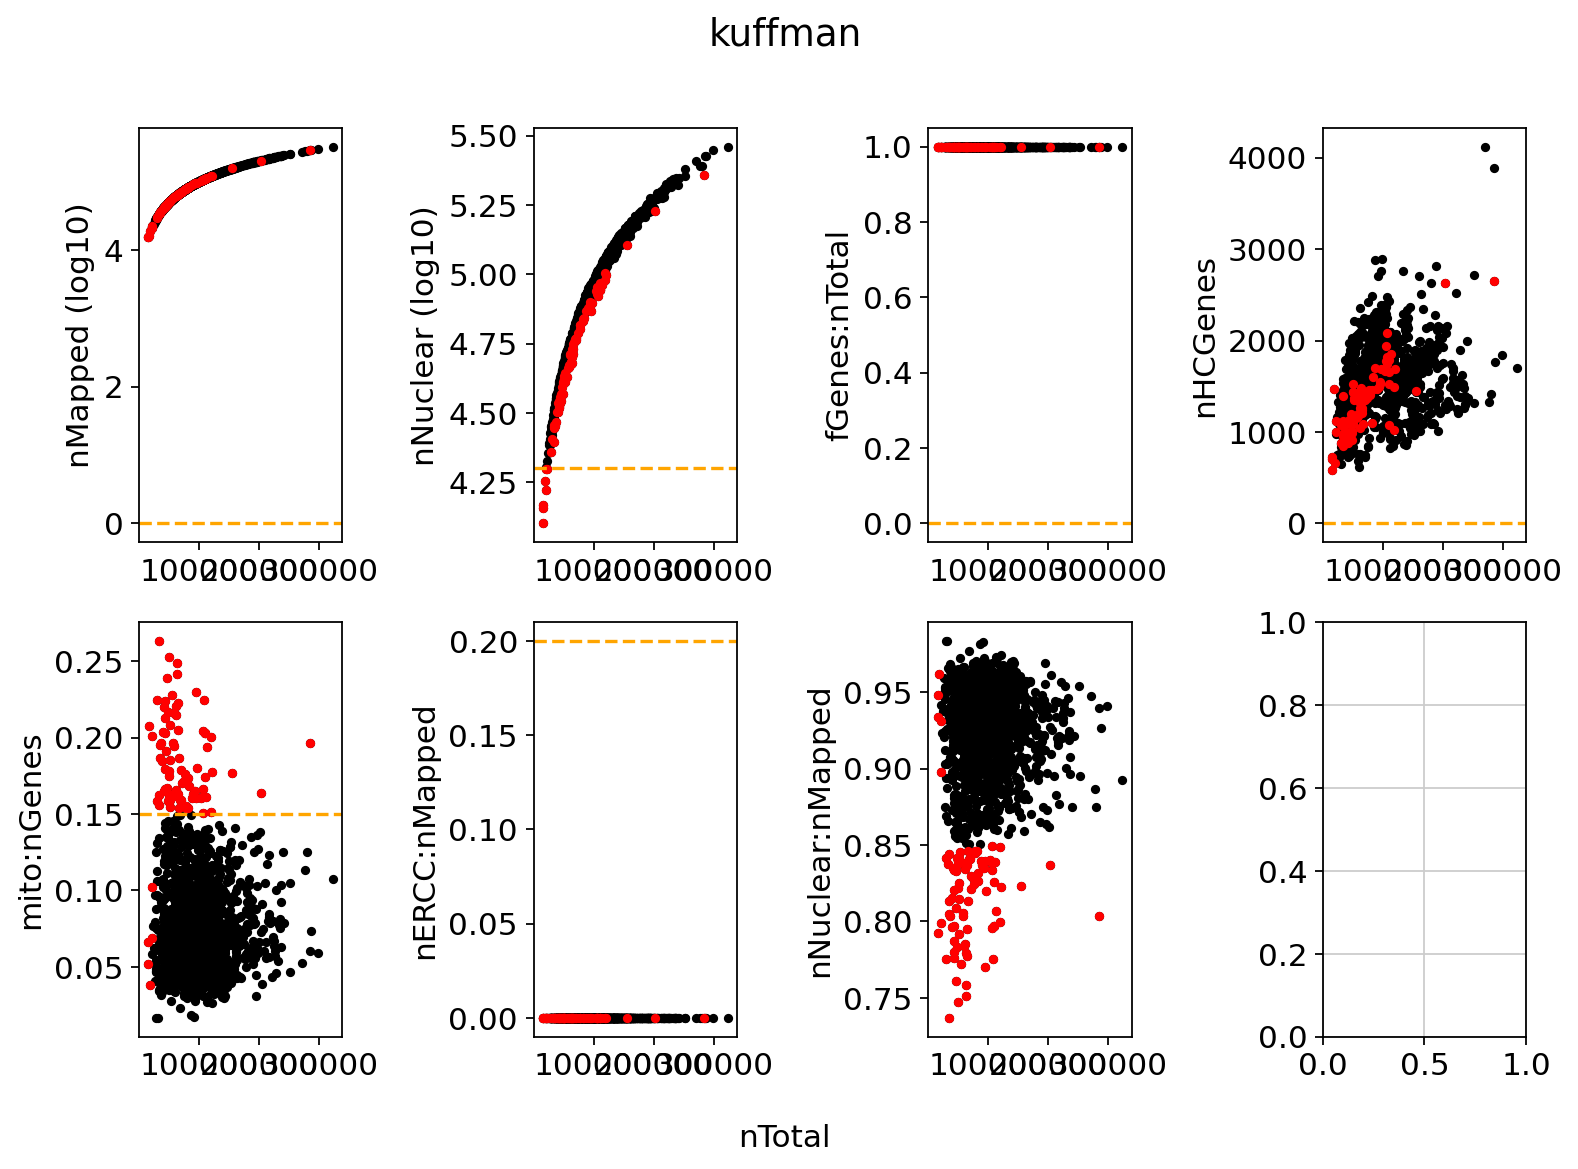

In [5]:
adata = smqpp.smartseq_qc(adata,cutoff=cutoff, title='kuffman', MTpattern='MT-')

In [6]:
adata

AnnData object with n_obs × n_vars = 1282 × 28970 
    obs: 'Donor', 'CD45RA', 'CD34', 'CD38', 'CD49f', 'CD90', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_MT', 'S.Score', 'G2M.Score', 'Cycle.Score', 'Cycling', 'DCA_split', 'n_counts', 'size_factors', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Tissue', 'percent_mito', 'n_genes'

In [7]:
adata.write('./write/kuffman_raw.h5ad')

... storing 'Donor' as categorical
... storing 'Cycling' as categorical
... storing 'DCA_split' as categorical
... storing 'Tissue' as categorical


# Normalisation

In [8]:
adata = sc.read('./write/kuffman_raw.h5ad')

In [9]:
# quick QC
sc.pp.filter_genes(adata, min_cells=1)
adata.var_names_make_unique()

adata_test = adata.copy()
smqpp.normalise_data(adata_test)

filtered out 247 genes that are detected in less than 1 cells
Calculate SF for genes:
Filtered matrix shape: (1282, 27)
Number of valid means:27


In [10]:
adata.write('./write/kuffman_norm.h5ad')

# Check for Cell Cycle

In [11]:
adata = sc.read('./write/kuffman_norm.h5ad')
adata.var_names_make_unique()
sc.pp.scale(adata)

cell_cycle_genes = [x.strip() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = np.intersect1d(cell_cycle_genes, adata.var_names)
print(len(s_genes))
print(len(g2m_genes))
print(len(cell_cycle_genes))

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# save cell cycle results
np.savetxt('phase.txt', adata.obs['phase'], delimiter='\t', fmt='%s')
np.savetxt('S_score.txt', adata.obs['S_score'], delimiter='\t')
np.savetxt('G2M_score.txt', adata.obs['G2M_score'], delimiter='\t')

43
54
94
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    817 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


# Select HVGs

MeanForFit:  5
2791
Length of HVGs: 423


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


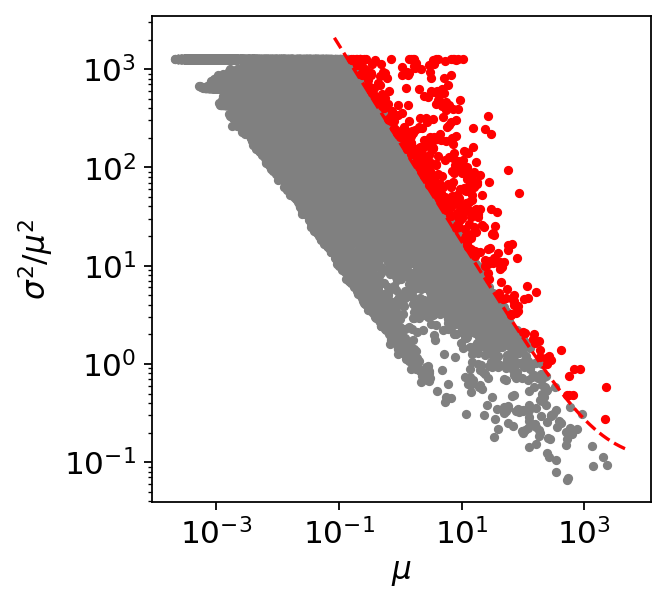

In [12]:
adata = sc.read('./write/kuffman_norm.h5ad')
adata.var_names_make_unique()
adata.obs['phase'] = np.genfromtxt('phase.txt', delimiter='\t', dtype=str)
adata.obs['S_score'] = np.genfromtxt('S_score.txt', delimiter='\t')
adata.obs['G2M_score'] = np.genfromtxt('G2M_score.txt', delimiter='\t')

smqpp.tech_var(adata_test, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata_test)

Number of selected Genes: 56
Number of outlier cell: 1
Outlier cells: ['onefilepercell_BM1_2_AACACGCATCTG_and_others_38YD9:BM4_4_CAGTCTACAGTG.fq_Aligned.sortedByCoord.out.bam-1']


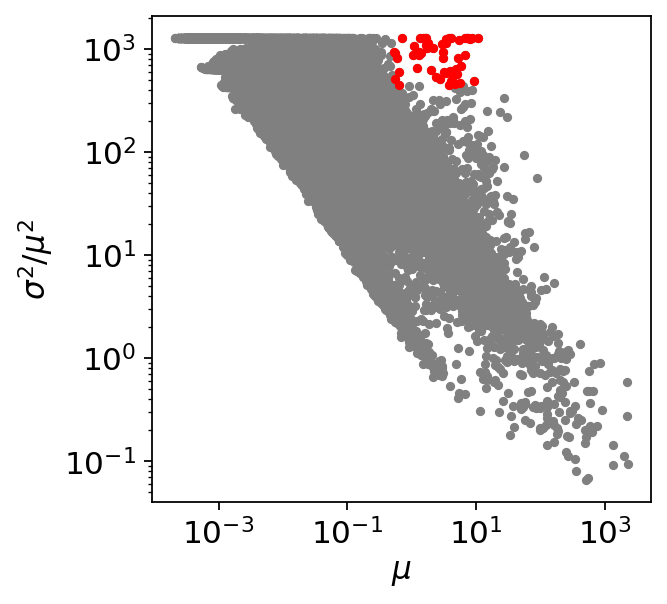

In [13]:
# Too few HVGs, could be effected by outlier cell
# Find outlier cells, we found one first, let's try to remove it
outlierC = smqpp.detect_outlier_cells(adata_test, aMeanQ=0.7, cv2aQ=0.6)

In [14]:
# Remove the outlier cell and run normalisation and HVG selection again
# and it worked! I don't have ERCC or QC data, so I just use the genes for HVG selection
adata = adata[adata.obs_names.values != outlierC, :].copy()
# remove genes with no counts
sc.pp.filter_genes(adata, min_cells=1)
adata.var_names_make_unique()

adata.write('./write/kuffman_raw.h5ad')

smqpp.normalise_data(adata)
adata.raw = adata

filtered out 3 genes that are detected in less than 1 cells


... storing 'phase' as categorical


Calculate SF for genes:
Filtered matrix shape: (1281, 30)
Number of valid means:30


MeanForFit:  5
2766
Length of HVGs: 2506


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


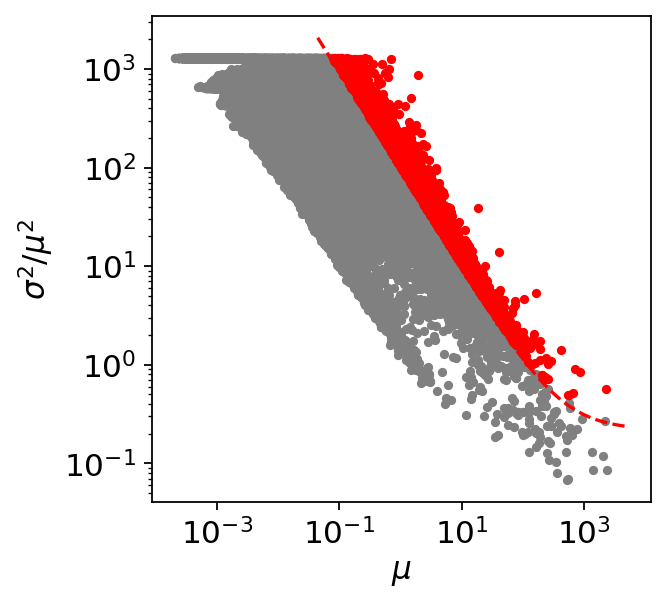

In [15]:
smqpp.tech_var(adata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata)

In [16]:
print(adata.shape)
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()
print(adata.shape)

(1281, 28720)
(1281, 2506)


# DR

In [17]:
# Scale the data for PCA then do other DR
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)
umap_ref = smqpp.quick_umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9269554  0.8759498  0.8520926  0.79625016 0.78115344
     0.747206   0.741871   0.735305   0.72900885 0.7232348  0.7177817
     0.7117174  0.7107033  0.70807904]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [18]:
print(adata.obs_keys())

['Donor', 'CD45RA', 'CD34', 'CD38', 'CD49f', 'CD90', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_MT', 'S.Score', 'G2M.Score', 'Cycle.Score', 'Cycling', 'DCA_split', 'n_counts', 'size_factors', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'Tissue', 'percent_mito', 'n_genes', 'phase', 'S_score', 'G2M_score', 'sf_gene']


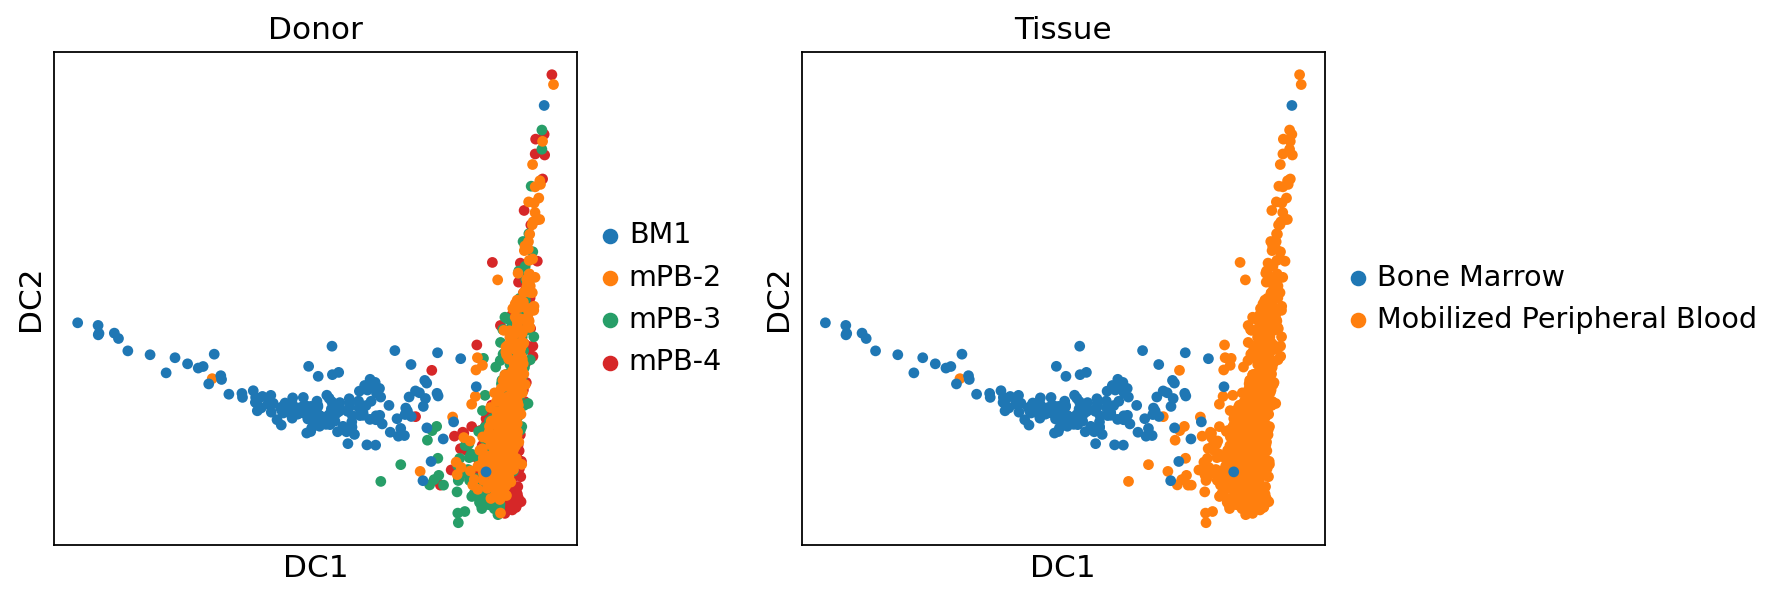

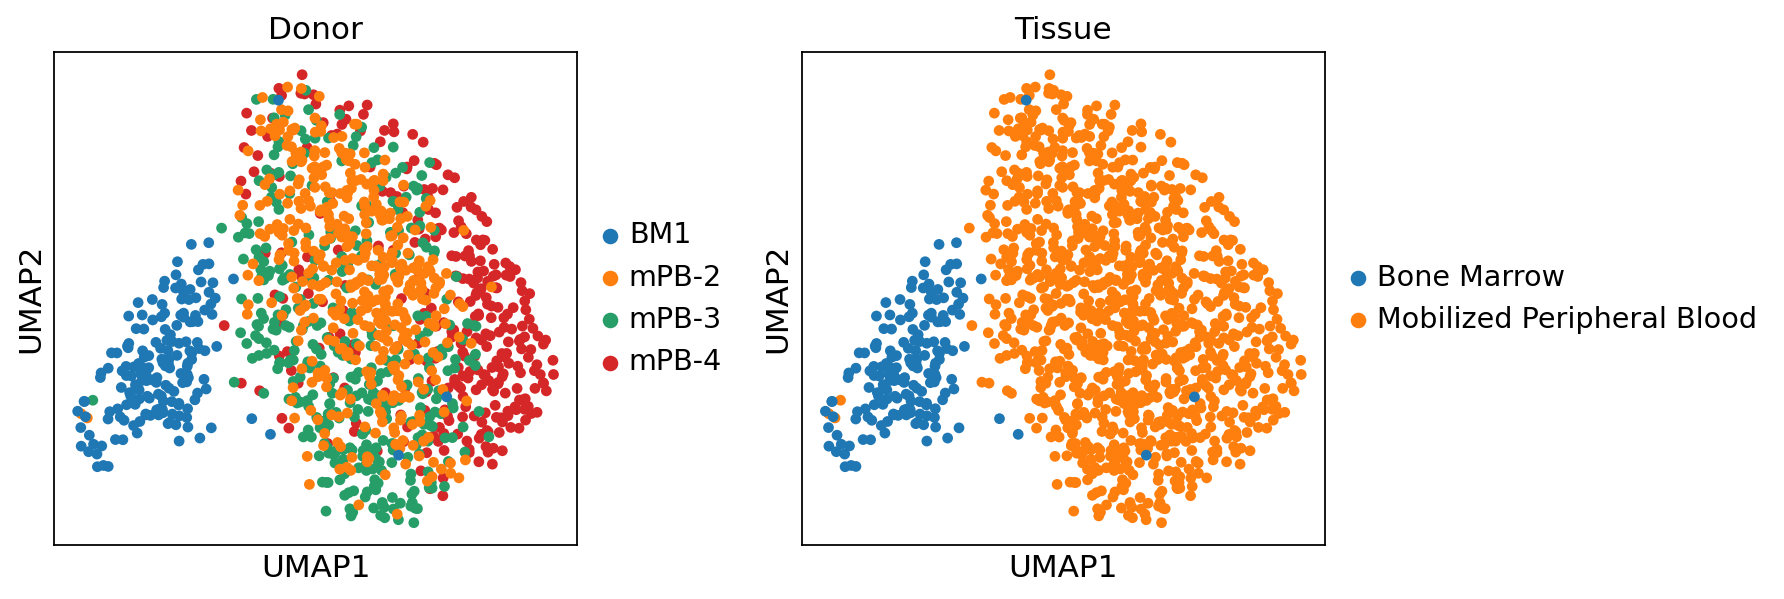

In [19]:
sc.pl.diffmap(adata, color=['Donor','Tissue'], wspace=0.3)
sc.pl.umap(adata, color=['Donor','Tissue'], wspace=0.3)

In [20]:
adata.write('./write/kuffman_processed.h5ad')

In [21]:
# Split by Cell Type and run separately
adata = sc.read('./write/kuffman_processed.h5ad')
adata_raw = sc.read('./write/kuffman_raw.h5ad')
adata_raw.obs = adata.obs
adata_BM = adata_raw[adata_raw.obs['Donor'] == 'BM1', :].copy()
adata_MPB = adata_raw[adata_raw.obs['Donor'] != 'BM1', :].copy()
adata_BM.write('./write/kuffman_raw_BM.h5ad')
adata_MPB.write('./write/kuffman_raw_MPB.h5ad')

# MPB

filtered out 741 genes that are detected in less than 1 cells
Calculate SF for genes:
Filtered matrix shape: (1109, 30)
Number of valid means:30
MeanForFit:  5
2845
Length of HVGs: 2402
(1109, 27979)


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


(1109, 2402)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


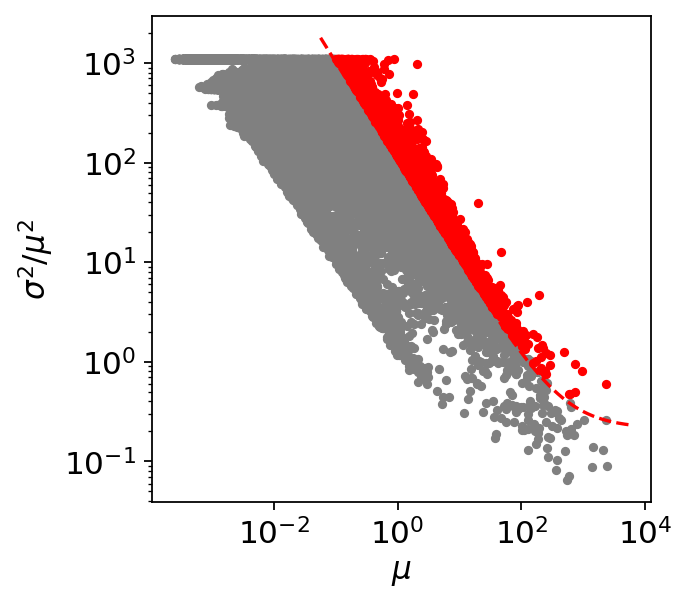

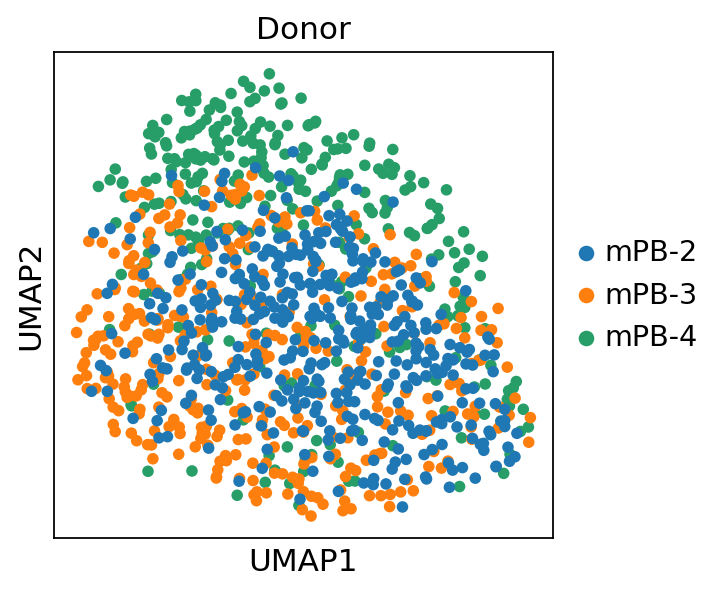

In [22]:
adata = sc.read('./write/kuffman_raw_MPB.h5ad')
sc.pp.filter_genes(adata, min_cells=1)
smqpp.normalise_data(adata)
adata.raw = adata

smqpp.tech_var(adata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata)
print(adata.shape)
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()
print(adata.shape)

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['Donor'])

In [23]:
# Correct batch effect
X_pca = adata.obsm['X_pca']
idx0 = adata.obs['Donor'] == 'mPB-2'
idx1 = adata.obs['Donor'] == 'mPB-3'
idx2 = adata.obs['Donor'] == 'mPB-4'
pca0 = pd.DataFrame(X_pca[idx0])
pca1 = pd.DataFrame(X_pca[idx1])
pca2 = pd.DataFrame(X_pca[idx2])

In [24]:
%reload_ext rpy2.ipython

In [25]:
%%R -i pca0 -i pca1 -i pca2 -o odf
suppressMessages(library("batchelor"))
odf = reducedMNN(data.matrix(pca0), data.matrix(pca1), data.matrix(pca2),
                      BPPARAM=MulticoreParam(detectCores()))
odf = data.frame(odf$corrected)

In [26]:
CNs = np.concatenate([adata.obs_names[x] for x in [idx0, idx1, idx2]])
adata = adata[CNs,:].copy()
adata.obsm['X_pca'] = odf.values

In [27]:
# recalcualte everything for visualisation
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)
umap_ref = smqpp.quick_umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.8810114  0.7760405  0.7516367  0.74695057 0.7368323
     0.7308156  0.7197282  0.71675634 0.7094742  0.7090687  0.70420396
     0.7027465  0.6981348  0.69694346]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


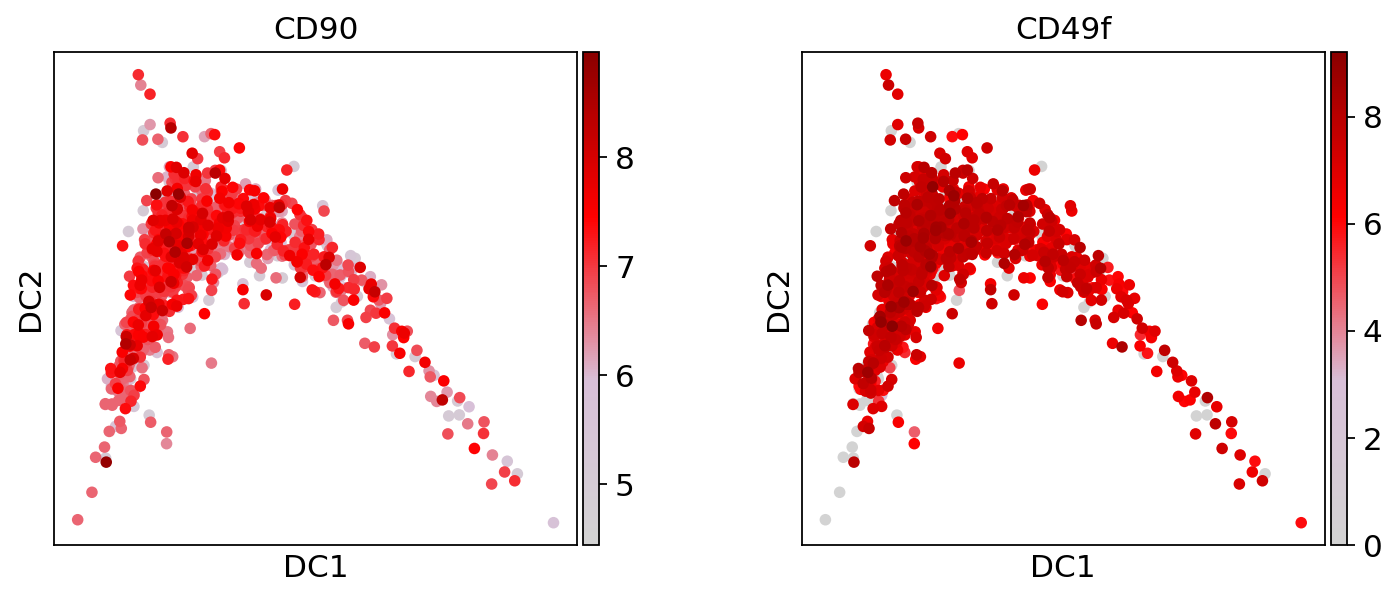

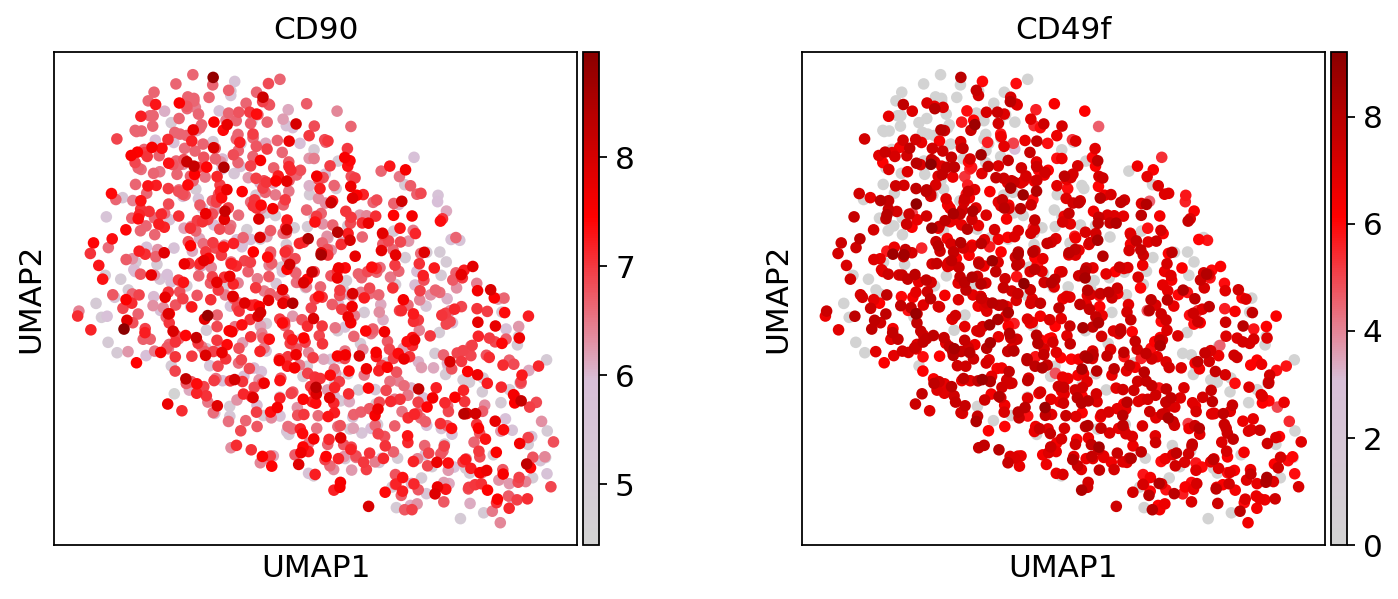

In [121]:
# check their genes
sc.pl.diffmap(adata, color=['CD90', 'CD49f'], color_map=cmap, wspace=0.3)
sc.pl.umap(adata, color=['CD90', 'CD49f'], color_map=cmap, wspace=0.3)

## check for cell cycle

In [76]:
adata_check = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/ycks3/laurenti/analysis_laurenti/serena/qa22_qa81_with_without_PD/toronto_projection_28Apr2020/scRNA_HSC_processed_withVelocity.h5ad')
adata_check = adata_check[adata.obs_names,:].copy()
print(adata_check.shape)

(1109, 10000)


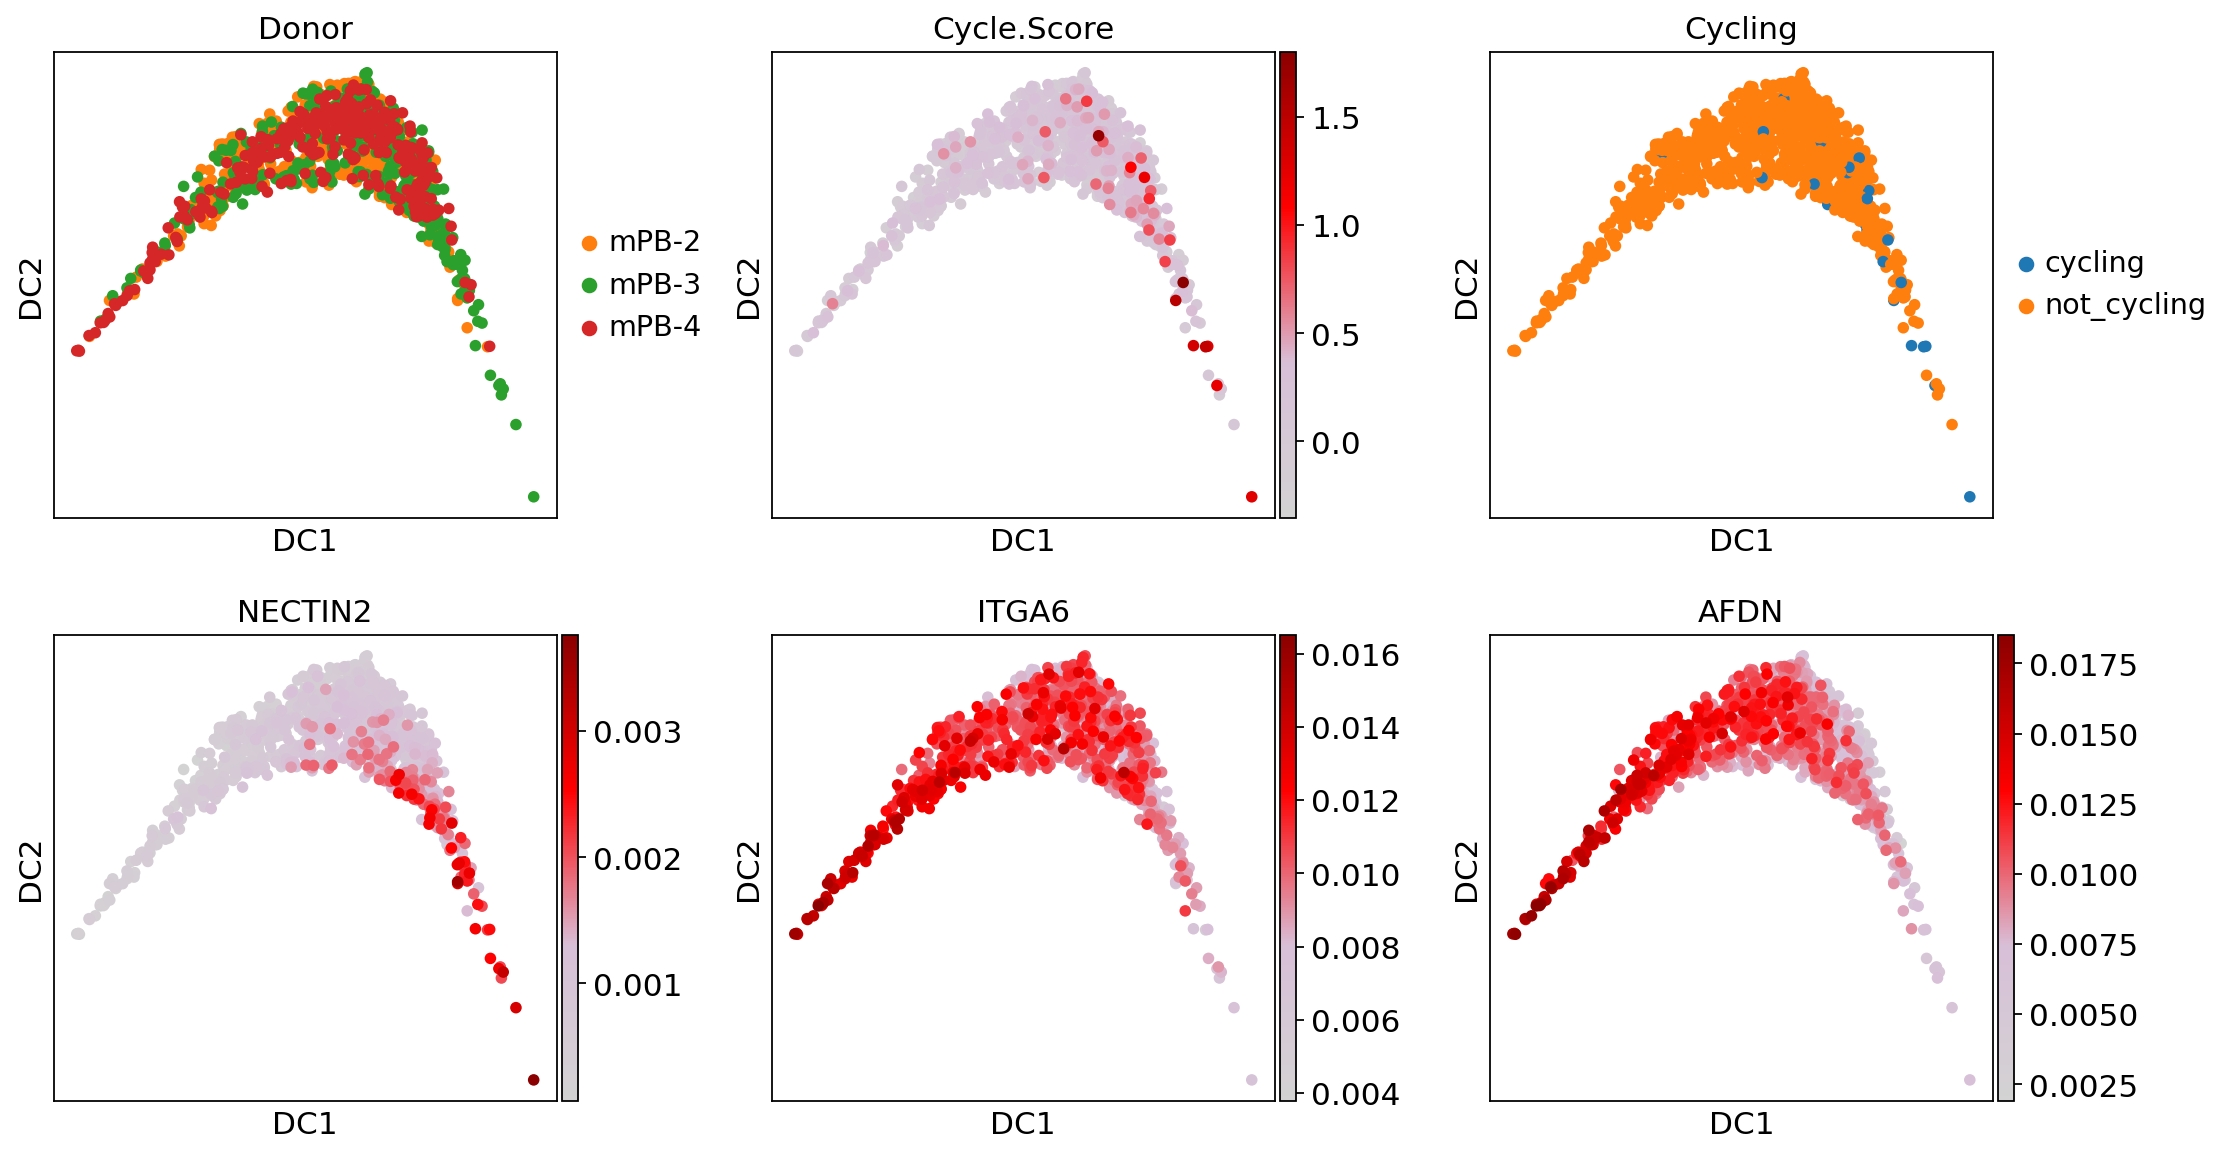

In [79]:
# check the cyling score
sc.pl.diffmap(adata_check, color=['Donor', 'Cycle.Score', 'Cycling', 'NECTIN2', 'ITGA6', 'AFDN'], ncols=3, color_map=cmap, wspace=0.3)

In [86]:
adata.obs['NECTIN2_impu'] = adata_check[:,'NECTIN2'].X.flatten()
adata.obs['ITGA6_impu'] = adata_check[:,'ITGA6'].X.flatten()
adata.obs['AFDN_impu'] = adata_check[:,'AFDN'].X.flatten()

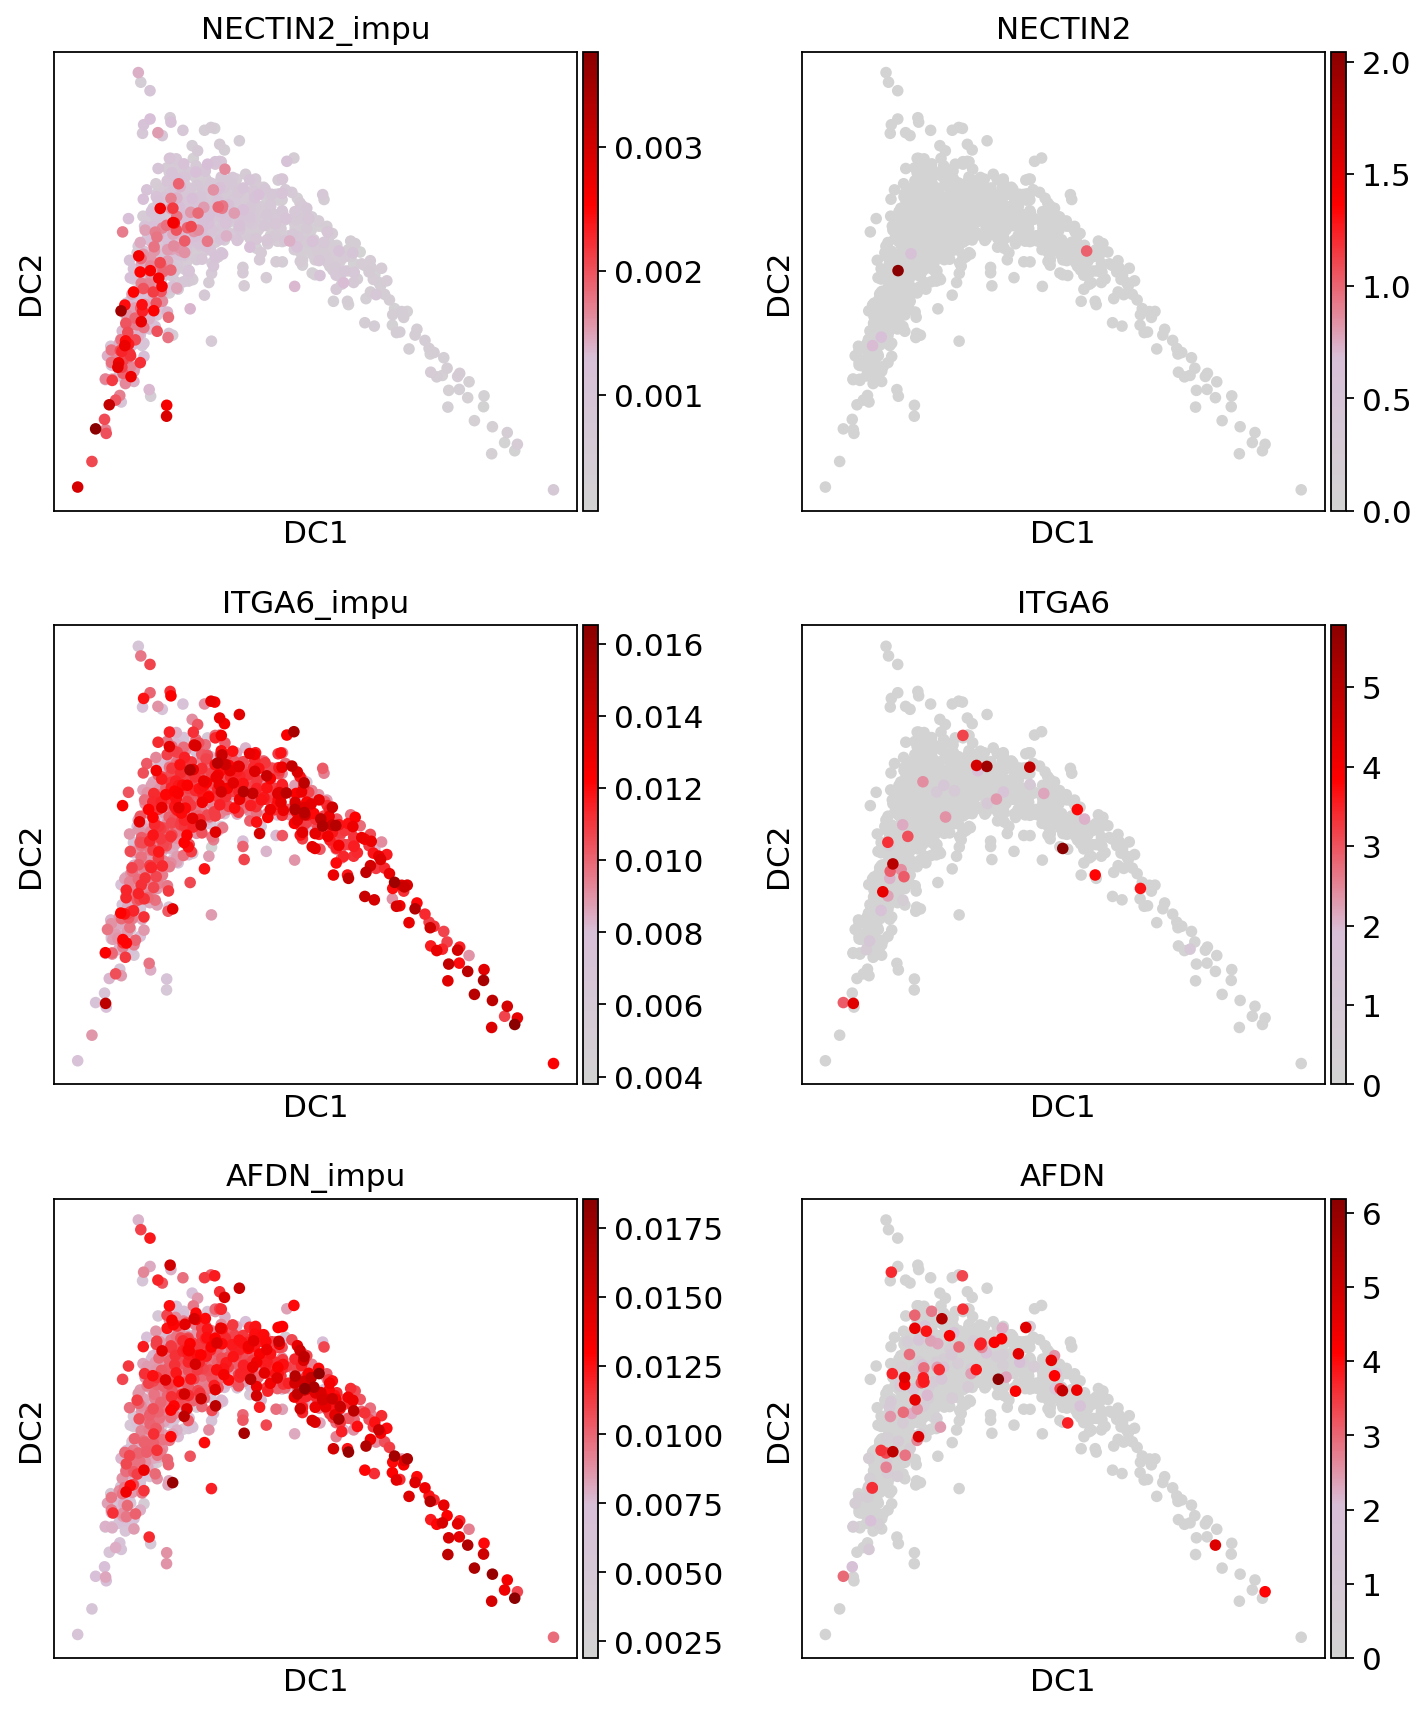

In [87]:
sc.pl.diffmap(adata, color=['NECTIN2_impu', 'NECTIN2', 
                            'ITGA6_impu', 'ITGA6', 
                            'AFDN_impu','AFDN'], color_map=cmap, wspace=0.3, ncols=2)

In [170]:
GOL = np.intersect1d(adata_check.var_names, adata.raw.var_names)
print(len(GOL))
COL = np.intersect1d(adata_check.obs_names, adata.obs_names)
print(len(COL))

9900
1109


In [175]:
X_check = adata_check[COL,GOL].X
X1 = adata.raw[COL,GOL].X

In [196]:
# distance between imputed and non-imputed
from scipy.stats import spearmanr,pearsonr
D_spearman = [(1-spearmanr(X_check[:,x], X1[:,x])[0])/2 for x in range(X_check.shape[1])]

In [206]:
PT = adata[COL,:].obs['dpt_pseudotime'].values

In [228]:
# cor between imputed and PT
# cor between non-imputed and PT
D_spearman_pt = [abs(spearmanr(X_check[:,x], PT)[0]) for x in range(X_check.shape[1])]
D_spearman_pt1 = [abs(spearmanr(X1[:,x], PT)[0]) for x in range(X_check.shape[1])]

In [193]:
gidx = np.in1d(GOL, np.array(['NECTIN2', 'ITGA6', 'AFDN']))

Text(0, 0.5, 'Dis btw imputed and non-imputed')

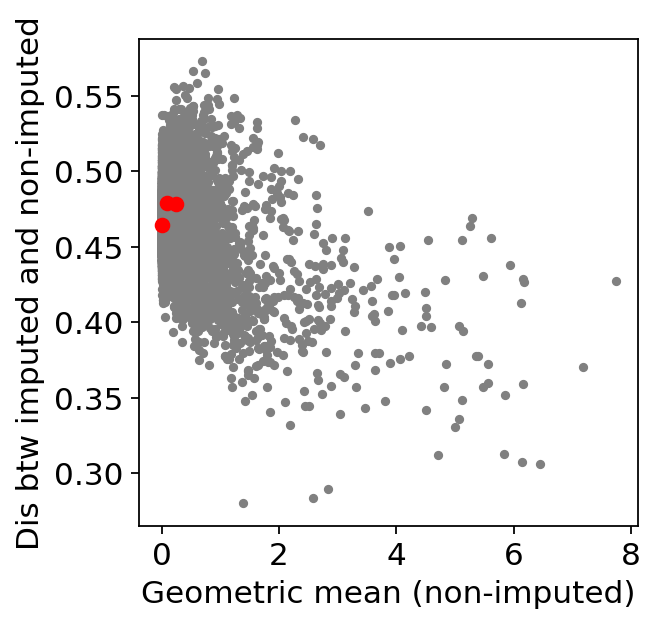

In [230]:
plt.scatter(np.mean(X1, axis=0),np.array(D_spearman), c='grey', s=10)
plt.scatter(np.mean(X1, axis=0)[gidx],np.array(D_spearman)[gidx], c='red')
plt.grid(False)
plt.xlabel('Geometric mean (non-imputed)')
plt.ylabel('Dis btw imputed and non-imputed')

Text(0, 0.5, 'spearman cor-imputed')

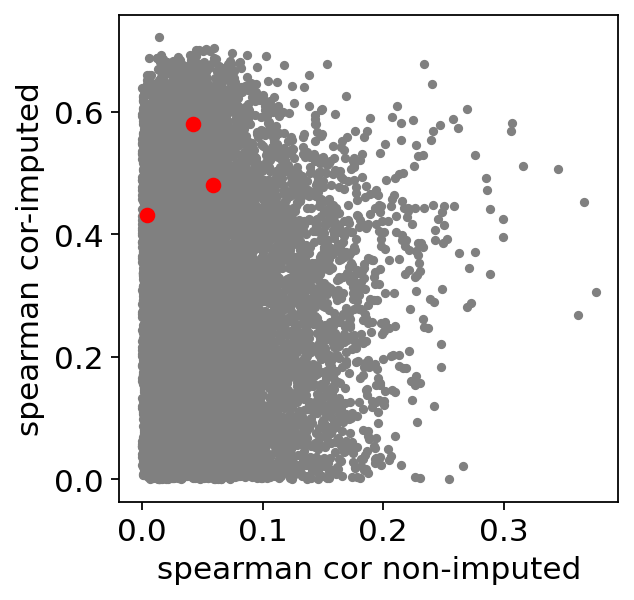

In [231]:
plt.scatter(np.array(D_spearman_pt1),np.array(D_spearman_pt),c='grey',s=10)
plt.scatter(np.array(D_spearman_pt1)[gidx],np.array(D_spearman_pt)[gidx], c='red')
plt.grid(False)
plt.xlabel('spearman cor non-imputed')
plt.ylabel('spearman cor-imputed')

In [132]:
from scipy.stats import zscore
adata.obs['phase_sum'] = zscore(adata.obs['S_score'] + adata.obs['G2M_score'])

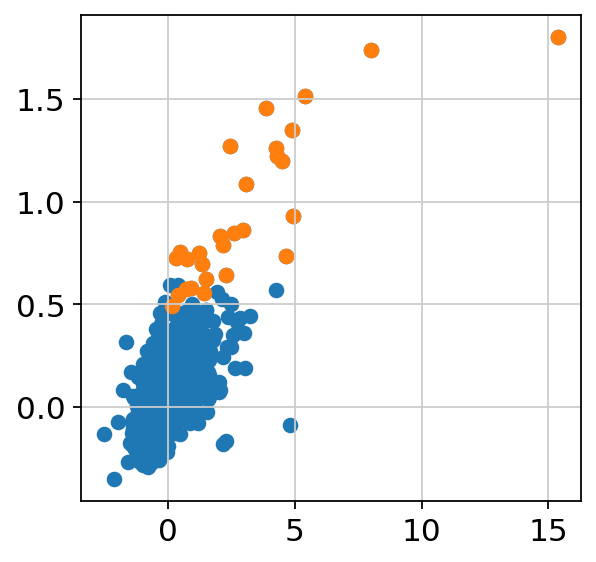

In [133]:
plt.scatter(adata.obs['phase_sum'], adata.obs['Cycle.Score'])
idx1 = adata.obs['Cycling'] == 'cycling'
plt.scatter(adata.obs['phase_sum'][idx1], adata.obs['Cycle.Score'][idx1])

## DPT and louvain

In [106]:
bgn_idx = np.where(adata.obsm['X_diffmap'][:,1] == np.max(adata.obsm['X_diffmap'][:,1]))[0][0]
print(bgn_idx)
adata.uns['iroot'] = bgn_idx
sc.tl.dpt(adata)

149
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [117]:
sc.tl.louvain(adata, resolution = 0.7)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [138]:
phase_comb =  {'G1': 'G1',
              'G2M': 'G2M/S',
              'S': 'G2M/S'}
adata.obs['phase_comb'] = [phase_comb[x] for x in adata.obs['phase']] 

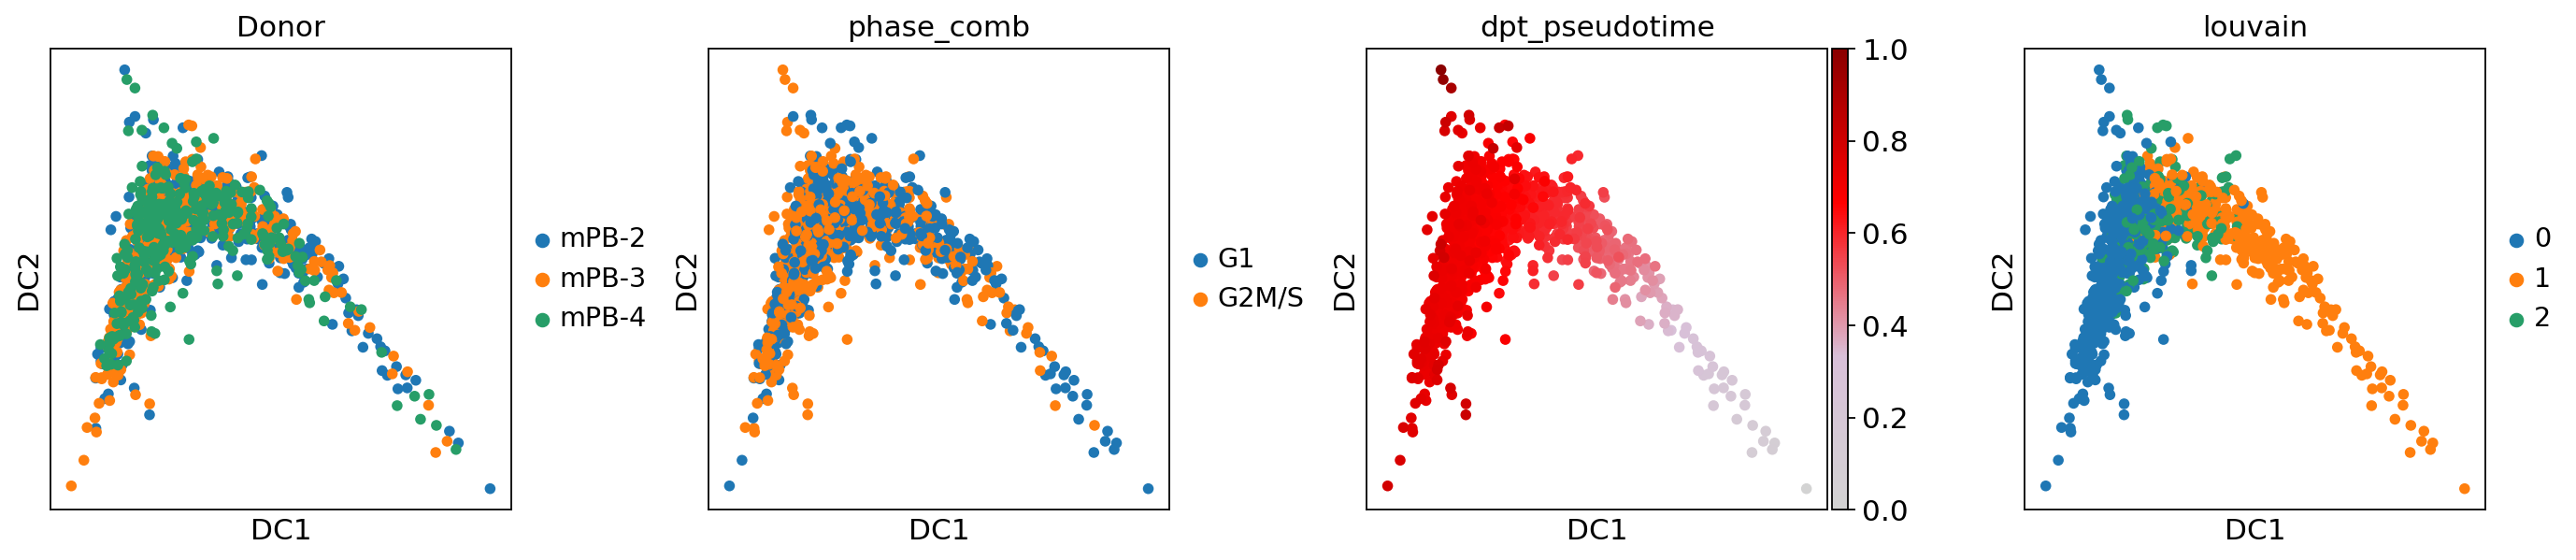

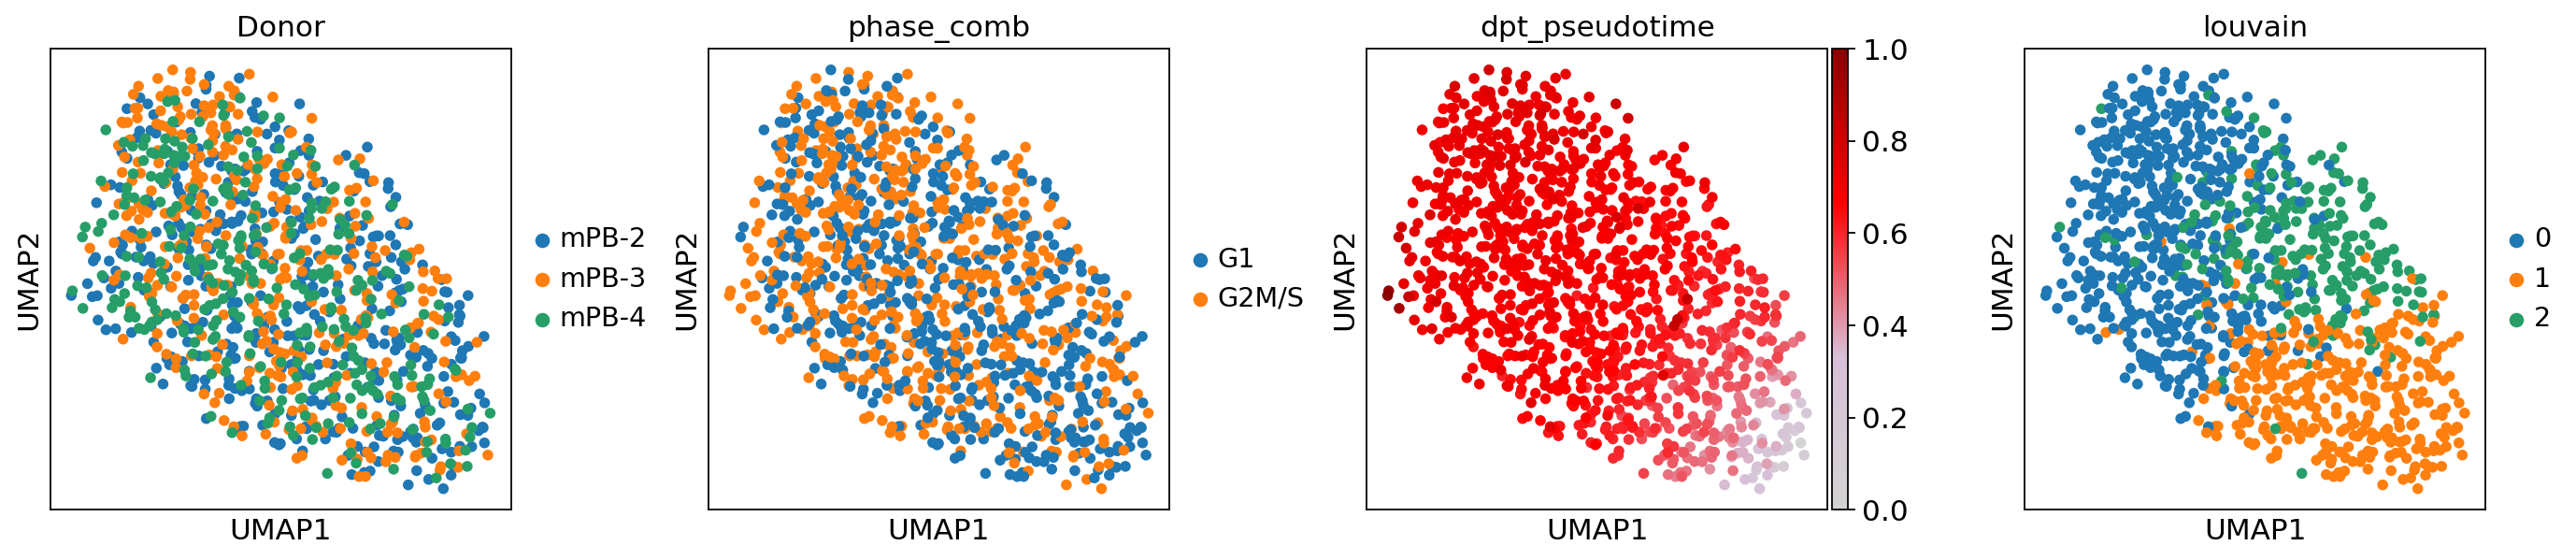

In [145]:
sc.pl.diffmap(adata, color=['Donor','phase_comb','dpt_pseudotime', 'louvain'], color_map=cmap, wspace=0.3, vmax=1)
sc.pl.umap(adata, color=['Donor', 'phase_comb', 'dpt_pseudotime', 'louvain'], color_map=cmap, wspace=0.3, vmax=1)

In [140]:
adata.write('./write/kuffman_processed_MPB.h5ad')

# BM

filtered out 10900 genes that are detected in less than 1 cells
Calculate SF for genes:
Filtered matrix shape: (172, 78)
Number of valid means:78
MeanForFit:  5
2140
Length of HVGs: 1035
(172, 17820)
(172, 1035)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.7751883   0.7053219   0.69087875  0.66368103  0.64973104
      0.639502    0.63382816  0.6148873   0.61236095 -0.59913236 -0.61003727
     -0.62033844 -0.6495725  -0.6785446 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


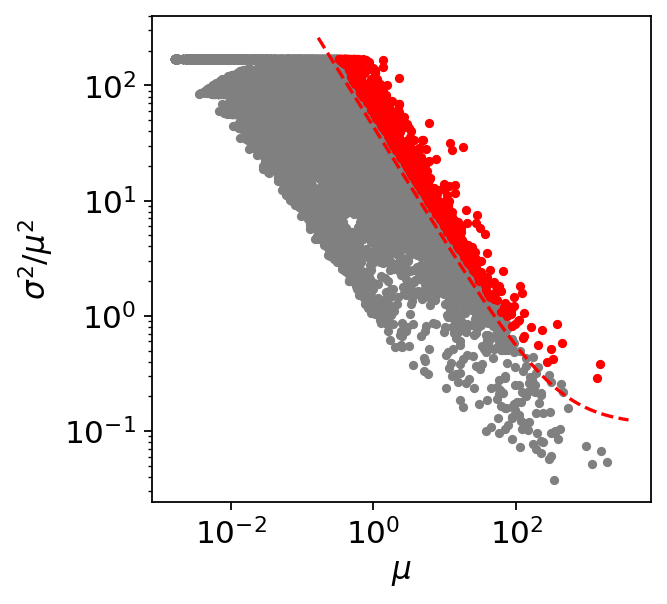

In [37]:
adata = sc.read('./write/kuffman_raw_BM.h5ad')
sc.pp.filter_genes(adata, min_cells=1)
smqpp.normalise_data(adata)
adata.raw = adata

smqpp.tech_var(adata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata)
print(adata.shape)
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()
print(adata.shape)

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)
umap_ref = smqpp.quick_umap(adata)

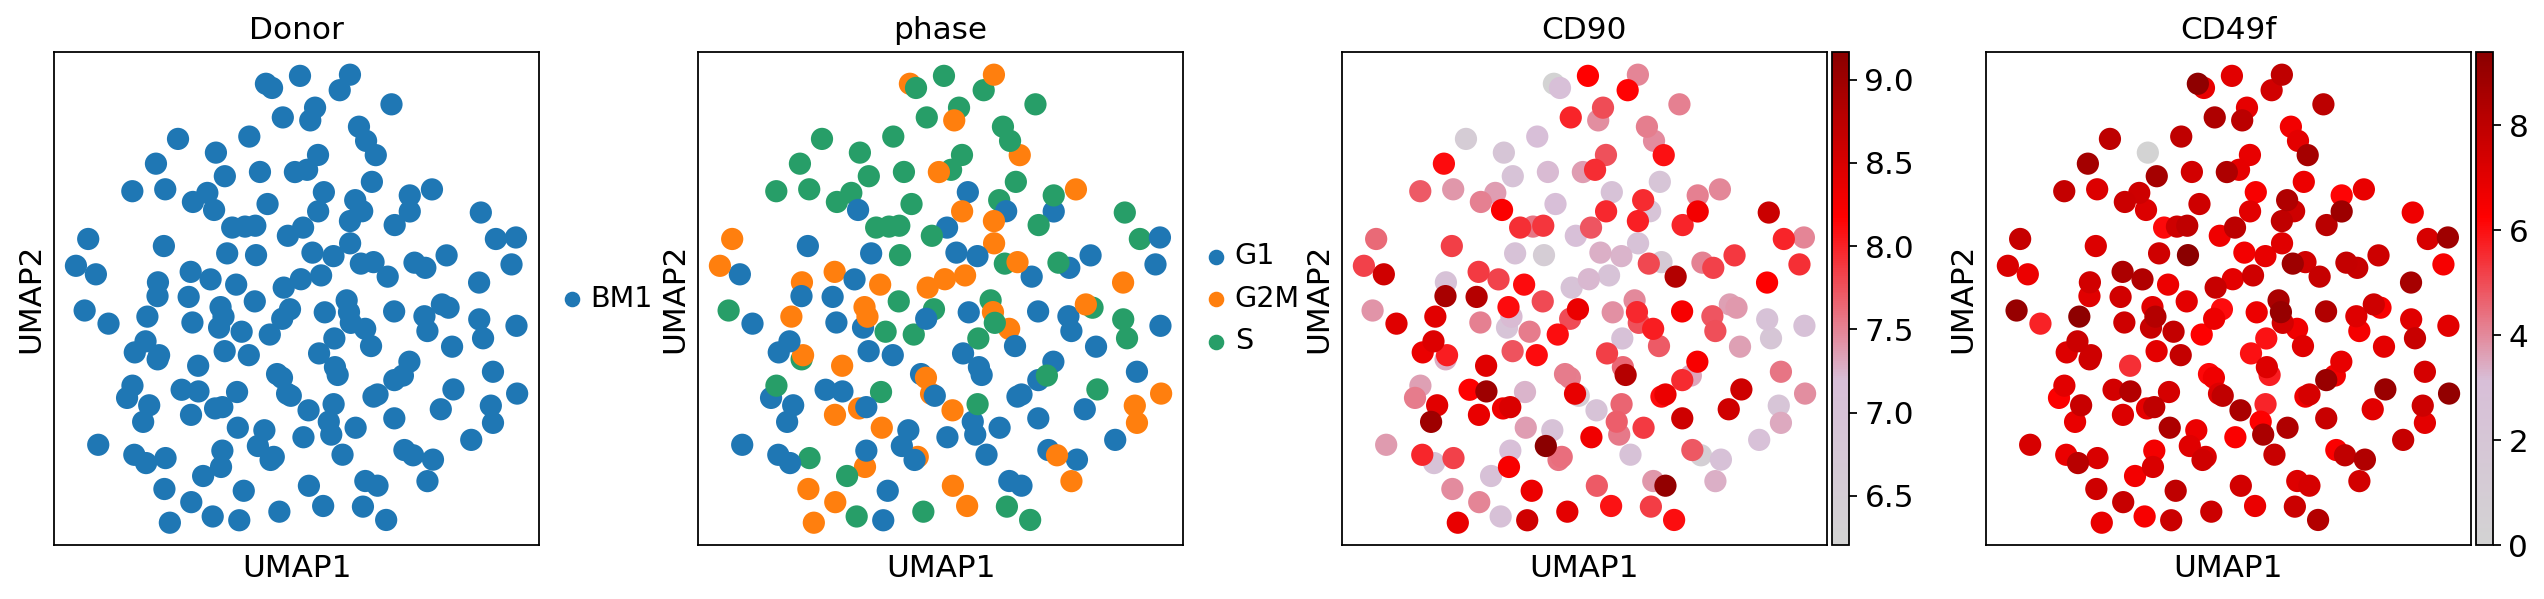

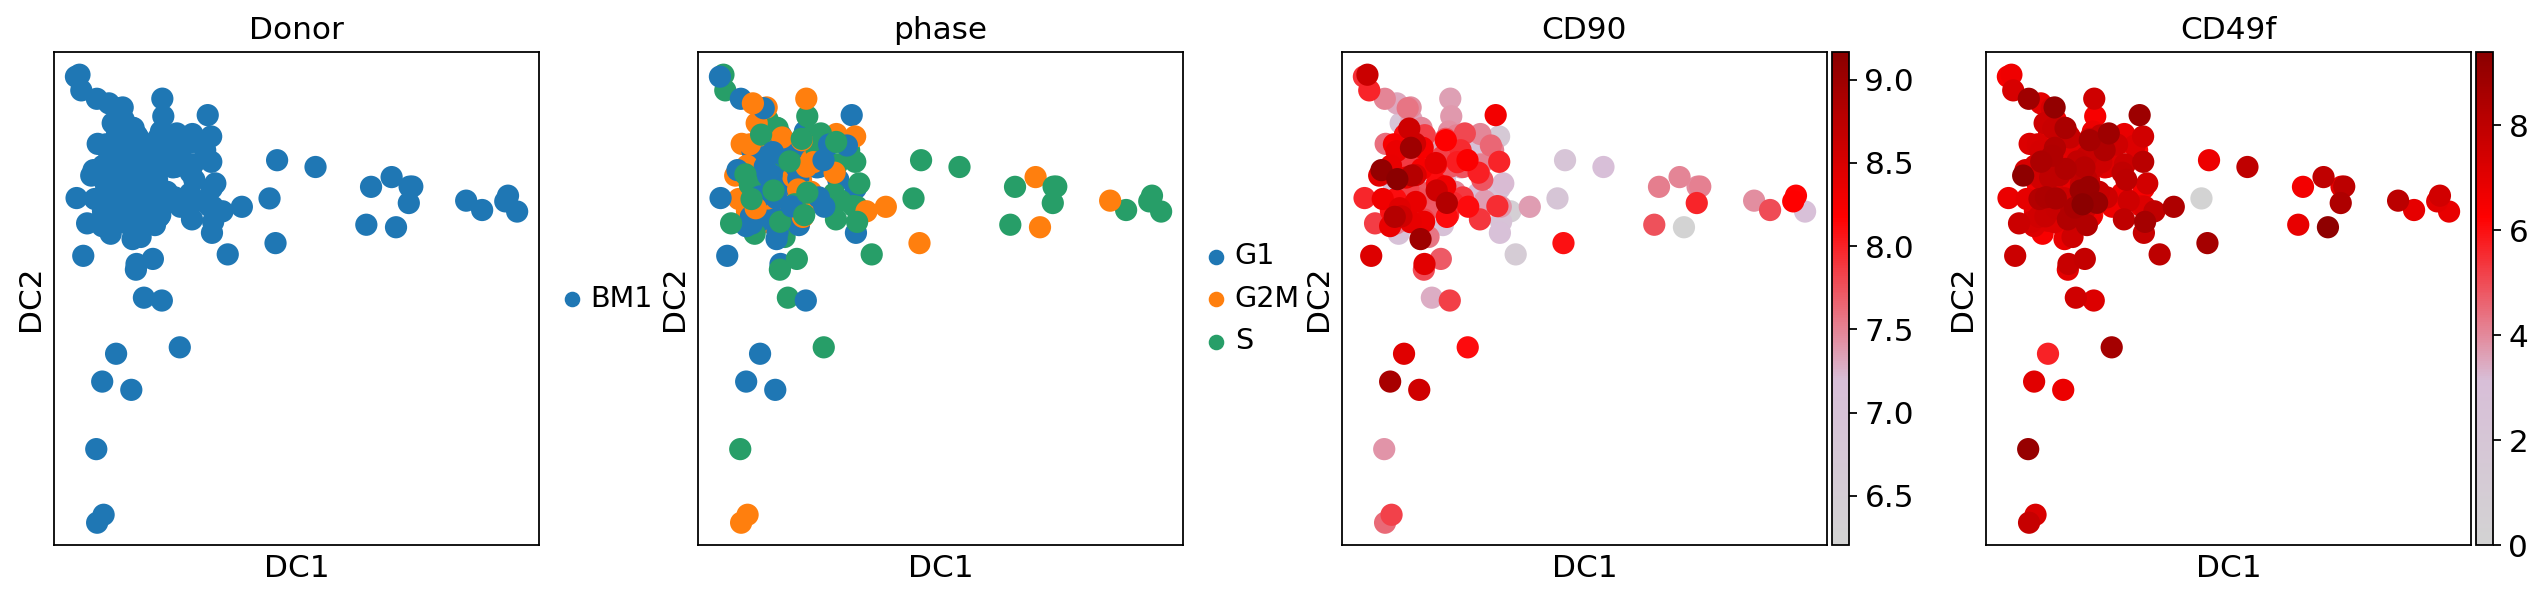

In [236]:
sc.pl.umap(adata, color=['Donor', 'phase', 'CD90', 'CD49f'], color_map=cmap, s=400)
sc.pl.diffmap(adata, color=['Donor', 'phase', 'CD90', 'CD49f'], color_map=cmap, s=400)

In [39]:
adata.write('./write/kuffman_processed_BM.h5ad')